In [1]:
import sys, os
sys.path.append(os.path.realpath(".."))
os.environ["TF_XLA_FLAGS"]="--tf_xla_cpu_global_jit"

import util_funcs
from importlib import reload
import data_reader as read
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import constants
import ensembleReader as er
import clinical_text_analysis as cta
import tsfresh
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from os import path
# import predictSeizureConvExp as psce
import keras_models.dataGen as dg
from addict import Dict
from pathlib import Path
# reload(psce)
from keras.utils import multi_gpu_model
import keras
import keras.optimizers
import time
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, log_loss
import math as math
import numpy as np
import scipy.io
from scipy.interpolate import griddata
from sklearn.preprocessing import scale
from functools import reduce, lru_cache
def gen_images(locs, features, n_gridpoints=32, normalize=True, edgeless=False):
    """
    Generates EEG images given electrode locations in 2D space and multiple feature values for each electrode
    :param locs: An array with shape [n_electrodes, 2] containing X, Y
                        coordinates for each electrode.
    :param features: Feature matrix as [n_samples, n_features]
                                Features are as columns.
                                Features corresponding to each frequency band are concatenated.
                                (alpha1, alpha2, ..., beta1, beta2,...)
    :param n_gridpoints: Number of pixels in the output images
    :param normalize:   Flag for whether to normalize each band over all samples
    :param edgeless:    If True generates edgeless images by adding artificial channels
                        at four corners of the image with value = 0 (default=False).
    :return:            Tensor of size [samples, colors, W, H] containing generated
                        images.
    """
    feat_array_temp = []
    nElectrodes = locs.shape[0]     # Number of electrodes
    # Test whether the feature vector length is divisible by number of electrodes
    assert features.shape[1] % nElectrodes == 0
    n_colors = features.shape[1] // nElectrodes
    for c in range(n_colors):
        feat_array_temp.append(features[:, c * nElectrodes : nElectrodes * (c+1)])  # features.shape为[samples, 3*nElectrodes]

    nSamples = features.shape[0]    # sample number 2670
    # Interpolate the values        # print(np.mgrid[-1:1:5j]) get [-1.  -0.5  0.   0.5  1. ]
    grid_x, grid_y = np.mgrid[
                     min(locs[:, 0]):max(locs[:, 0]):n_gridpoints*1j,
                     min(locs[:, 1]):max(locs[:, 1]):n_gridpoints*1j
                     ]
    
    temp_interp = []
    for c in range(n_colors):
        temp_interp.append(np.zeros([nSamples, n_gridpoints, n_gridpoints]))

    
    # Generate edgeless images
    if edgeless:
        min_x, min_y = np.min(locs, axis=0)
        max_x, max_y = np.max(locs, axis=0)
        locs = np.append(locs, np.array([[min_x, min_y], [min_x, max_y],[max_x, min_y],[max_x, max_y]]),axis=0)
        for c in range(n_colors):
            feat_array_temp[c] = np.append(feat_array_temp[c], np.zeros((nSamples, 4)), axis=1)
    
    # Interpolating
    for i in range(nSamples):
        for c in range(n_colors):
            temp_interp[c][i, :, :] = griddata(locs, feat_array_temp[c][i, :], (grid_x, grid_y),    # cubic
                                    method='cubic', fill_value=np.nan)
    
#     # Normalizing
#     for c in range(n_colors):
#         if normalize:
#             temp_interp[c][~np.isnan(temp_interp[c])] = \
#                 scale(temp_interp[c][~np.isnan(temp_interp[c])])
        
#         temp_interp[c] = np.nan_to_num(temp_interp[c])
        
    temp_interp = np.swapaxes(np.asarray(temp_interp), 0, 1)     # swap axes to have [samples, colors, W, H] # WH xy
    temp_interp = np.swapaxes(temp_interp, 1, 2)
    temp_interp = np.swapaxes(temp_interp, 2, 3)    # [samples, W, H，colors]
    return temp_interp
def cart2sph(x, y, z):
    """
    Transform Cartesian coordinates to spherical
    :param x: X coordinate
    :param y: Y coordinate
    :param z: Z coordinate
    :return: radius, elevation, azimuth
    """
    x2_y2 = x**2 + y**2
    r = math.sqrt(x2_y2 + z**2)                    # r     tant^(-1)(y/x)
    elev = math.atan2(z, math.sqrt(x2_y2))            # Elevation
    az = math.atan2(y, x)                          # Azimuth
    return r, elev, az


def pol2cart(theta, rho):
    """
    Transform polar coordinates to Cartesian 
    :param theta: angle value
    :param rho: radius value
    :return: X, Y
    """
    return rho * math.cos(theta), rho * math.sin(theta)

@lru_cache(300)
def azim_proj(pos):
    """
    Computes the Azimuthal Equidistant Projection of input point in 3D Cartesian Coordinates.
    Imagine a plane being placed against (tangent to) a globe. If
    a light source inside the globe projects the graticule onto
    the plane the result would be a planar, or azimuthal, map
    projection.
    :param pos: position in 3D Cartesian coordinates    [x, y, z]
    :return: projected coordinates using Azimuthal Equidistant Projection
    """
    [r, elev, az] = cart2sph(pos[0], pos[1], pos[2])
    return pol2cart(az, math.pi / 2 - elev)

Using TensorFlow backend.


In [3]:
locations = pd.read_csv("../assets/3d_positions.csv")
projections = pd.DataFrame(locations[["x", "y", "z"]].apply(lambda x: azim_proj(x), axis=1).tolist(), columns=["x_proj", "y_proj"])
projections.loc[:,"channels"] = locations.label

TypeError: ("'Series' objects are mutable, thus they cannot be hashed", 'occurred at index 0')

In [2]:
train_data = pkl.load(open("/n/scratch2/ms994/train_montage_subtype.pkl", "rb"))

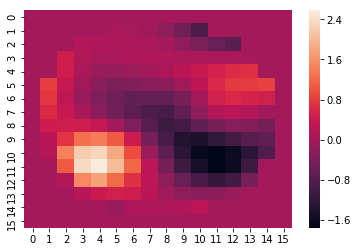

In [22]:
import seaborn as sns
sns.heatmap(np.apply_along_axis(gen_image_from_snapshot, 1, train_data[0][0])[0])

In [25]:
def transform_xy_to_image(data, toRunQ, toReturnQ):
    for i in iter(toRunQ.get, None):
        if i%50 == 0:
            print(f"{i}/{len(data)}")
        x, y = data[i]
        x = np.apply_along_axis(gen_image_from_snapshot, 1, x)
        toReturnQ.put((x,y))
def gen_image_from_snapshot(snapshot):
    return np.nan_to_num(gen_images(projections[["x_proj", "y_proj"]].values, snapshot.reshape(1,21),  n_gridpoints=16).reshape((16,16)))

In [30]:
from multiprocessing import Process, Manager
manager = Manager()
toRunQ = manager.Queue()
toReturnQ = manager.Queue()
n_process = 12
processes = [Process(target=transform_xy_to_image, args=(train_data, toRunQ, toReturnQ)) for i in range(n_process)]
[toRunQ.put(i) for i in range(len(train_data))]
[toRunQ.put(None) for i in range(n_process)]
print("setup")

setup


In [ ]:
[p.start() for p in processes]
[p.join() for p in processes]

0/203894
50/203894
100/203894
150/203894
200/203894
250/203894
300/203894
350/203894
400/203894
450/203894
500/203894
550/203894
600/203894
650/203894
700/203894
750/203894
800/203894
850/203894
900/203894
950/203894
1000/203894
1050/203894
1100/203894
1150/203894
1200/203894
1250/203894
1300/203894
1350/203894
1400/203894
1450/203894
1500/203894
1550/203894
1600/203894
1650/203894
1700/203894
1750/203894
1800/203894
1850/203894
1900/203894
1950/203894
2000/203894
2050/203894
2100/203894
2150/203894
2200/203894
2250/203894
2300/203894
2350/203894
2400/203894
2450/203894
2500/203894
2550/203894
2600/203894
2650/203894
2700/203894


In [ ]:
collected = []
while not toRunQ.empty():
    to